<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S10/EVA4_S10_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Initialization

Import required modules

In [1]:
# !pip install albumentations==0.4.5

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from data.data_engine import DataEngine
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
from gradcam.visualize import VisualizeCam
from lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


## Model Configuration and Set Seed

View model configuration and set the seed

In [2]:
# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 128,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


## Data Loading and Visualization

Preprocess and load the cifar10 dataset. Visualise the dataset.

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
plane   dog  deer  deer


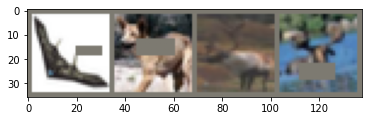

In [3]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

## Model

Create model and display model summary

In [4]:
device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### LR Finder

Increase the learning rate linearly and computes the evaluation loss for each learning rate.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


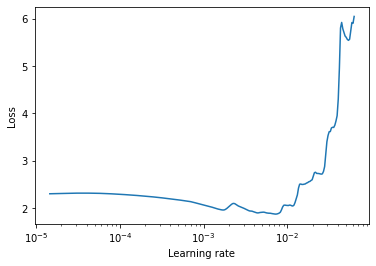

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-5, end_lr=2,
                     num_iter=len(data.train_loader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [6]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))
args.lr = best_lr

Best Loss: 1.876451529501383
Best Learning Rate: 0.007255346038874367


## Training and Testing

Train the model and evaluate it

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                              verbose=True, min_lr=1e-5)

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
      scheduler.step(test_losses[-1])
  return train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=459.5271301269531 L1_loss=109020.5859375 Loss=1.9654555320739746 Batch_id=390 Accuracy=48.14: 100%|██████████| 391/391 [00:30<00:00, 12.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 6426/10000 (64.26%)

EPOCH: 2


L2_loss=459.8738708496094 L1_loss=108531.5 Loss=1.7831364870071411 Batch_id=390 Accuracy=66.10: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 6871/10000 (68.71%)

EPOCH: 3


L2_loss=459.8817138671875 L1_loss=108012.8671875 Loss=1.5963757038116455 Batch_id=390 Accuracy=72.89: 100%|██████████| 391/391 [00:30<00:00, 12.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0064, Accuracy: 7302/10000 (73.02%)

EPOCH: 4


L2_loss=459.79736328125 L1_loss=107488.875 Loss=1.5418574810028076 Batch_id=390 Accuracy=76.62: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0049, Accuracy: 7828/10000 (78.28%)

EPOCH: 5


L2_loss=459.5829162597656 L1_loss=106957.25 Loss=1.3604915142059326 Batch_id=390 Accuracy=79.53: 100%|██████████| 391/391 [00:30<00:00, 12.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0048, Accuracy: 7953/10000 (79.53%)

EPOCH: 6


L2_loss=459.316650390625 L1_loss=106438.3515625 Loss=1.419071912765503 Batch_id=390 Accuracy=81.46: 100%|██████████| 391/391 [00:30<00:00, 12.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0045, Accuracy: 8141/10000 (81.41%)

EPOCH: 7


L2_loss=459.0440979003906 L1_loss=105946.6953125 Loss=1.4848084449768066 Batch_id=390 Accuracy=82.62: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0038, Accuracy: 8344/10000 (83.44%)

EPOCH: 8


L2_loss=458.75408935546875 L1_loss=105466.921875 Loss=1.390920877456665 Batch_id=390 Accuracy=83.93: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0038, Accuracy: 8329/10000 (83.29%)

EPOCH: 9


L2_loss=458.4142761230469 L1_loss=104994.2734375 Loss=1.2946269512176514 Batch_id=390 Accuracy=85.22: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0041, Accuracy: 8330/10000 (83.30%)

EPOCH: 10


L2_loss=458.0552673339844 L1_loss=104534.6640625 Loss=1.213446855545044 Batch_id=390 Accuracy=86.26: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8337/10000 (83.37%)

EPOCH: 11


L2_loss=457.6473083496094 L1_loss=104085.59375 Loss=1.4681293964385986 Batch_id=390 Accuracy=87.12: 100%|██████████| 391/391 [00:30<00:00, 12.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0034, Accuracy: 8616/10000 (86.16%)

EPOCH: 12


L2_loss=457.236328125 L1_loss=103646.7265625 Loss=1.0418295860290527 Batch_id=390 Accuracy=88.10: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0033, Accuracy: 8630/10000 (86.30%)

EPOCH: 13


L2_loss=456.8109436035156 L1_loss=103210.453125 Loss=1.0601909160614014 Batch_id=390 Accuracy=88.77: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0045, Accuracy: 8279/10000 (82.79%)

EPOCH: 14


L2_loss=456.3385314941406 L1_loss=102777.765625 Loss=1.070878028869629 Batch_id=390 Accuracy=89.13: 100%|██████████| 391/391 [00:30<00:00, 12.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0033, Accuracy: 8651/10000 (86.51%)

EPOCH: 15


L2_loss=455.8905334472656 L1_loss=102362.5078125 Loss=0.9386252760887146 Batch_id=390 Accuracy=89.75: 100%|██████████| 391/391 [00:30<00:00, 12.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0037, Accuracy: 8590/10000 (85.90%)

EPOCH: 16


L2_loss=455.4124755859375 L1_loss=101951.3984375 Loss=1.0461065769195557 Batch_id=390 Accuracy=90.37: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8608/10000 (86.08%)

EPOCH: 17


L2_loss=454.8939208984375 L1_loss=101534.0234375 Loss=1.1011359691619873 Batch_id=390 Accuracy=90.79: 100%|██████████| 391/391 [00:30<00:00, 12.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0033, Accuracy: 8690/10000 (86.90%)

EPOCH: 18


L2_loss=454.3946533203125 L1_loss=101149.484375 Loss=0.9786126613616943 Batch_id=390 Accuracy=91.18: 100%|██████████| 391/391 [00:30<00:00, 12.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8697/10000 (86.97%)

EPOCH: 19


L2_loss=453.87469482421875 L1_loss=100747.7421875 Loss=1.061654806137085 Batch_id=390 Accuracy=91.62: 100%|██████████| 391/391 [00:30<00:00, 12.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0037, Accuracy: 8589/10000 (85.89%)

EPOCH: 20


L2_loss=453.3548278808594 L1_loss=100363.03125 Loss=0.9432581663131714 Batch_id=390 Accuracy=91.93: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8816/10000 (88.16%)

EPOCH: 21


L2_loss=452.77630615234375 L1_loss=99967.0859375 Loss=0.9978746771812439 Batch_id=390 Accuracy=92.20: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0031, Accuracy: 8794/10000 (87.94%)

EPOCH: 22


L2_loss=452.1521911621094 L1_loss=99568.1796875 Loss=0.9598040580749512 Batch_id=390 Accuracy=92.72: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0034, Accuracy: 8720/10000 (87.20%)

EPOCH: 23


L2_loss=451.5623474121094 L1_loss=99171.5703125 Loss=0.9276936054229736 Batch_id=390 Accuracy=92.85: 100%|██████████| 391/391 [00:30<00:00, 12.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8881/10000 (88.81%)

EPOCH: 24


L2_loss=450.9345703125 L1_loss=98793.046875 Loss=1.053748607635498 Batch_id=390 Accuracy=92.99: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0036, Accuracy: 8655/10000 (86.55%)

EPOCH: 25


L2_loss=450.3063049316406 L1_loss=98408.875 Loss=0.8825575113296509 Batch_id=390 Accuracy=93.28: 100%|██████████| 391/391 [00:30<00:00, 12.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8813/10000 (88.13%)

EPOCH: 26


L2_loss=449.6185302734375 L1_loss=98007.53125 Loss=0.8601512908935547 Batch_id=390 Accuracy=93.60: 100%|██████████| 391/391 [00:30<00:00, 12.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8826/10000 (88.26%)

EPOCH: 27


L2_loss=448.96441650390625 L1_loss=97627.46875 Loss=0.9621517658233643 Batch_id=390 Accuracy=93.87: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0035, Accuracy: 8737/10000 (87.37%)

Epoch    27: reducing learning rate of group 0 to 7.2553e-04.
EPOCH: 28


L2_loss=448.7493896484375 L1_loss=97510.0546875 Loss=0.8309234976768494 Batch_id=390 Accuracy=96.07: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 93 %
Accuracy of  bird : 87 %
Accuracy of   cat : 69 %
Accuracy of  deer : 94 %
Accuracy of   dog : 82 %
Accuracy of  frog : 96 %
Accuracy of horse : 91 %
Accuracy of  ship : 96 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0024, Accuracy: 9119/10000 (91.19%)

EPOCH: 29


L2_loss=448.542724609375 L1_loss=97393.453125 Loss=0.8517767190933228 Batch_id=390 Accuracy=96.86: 100%|██████████| 391/391 [00:30<00:00, 12.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 95 %
Accuracy of   cat : 80 %
Accuracy of  deer : 88 %
Accuracy of   dog : 74 %
Accuracy of  frog : 90 %
Accuracy of horse : 100 %
Accuracy of  ship : 96 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0023, Accuracy: 9131/10000 (91.31%)

EPOCH: 30


L2_loss=448.3332824707031 L1_loss=97278.1796875 Loss=0.8134640455245972 Batch_id=390 Accuracy=96.99: 100%|██████████| 391/391 [00:30<00:00, 12.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 97 %
Accuracy of  bird : 89 %
Accuracy of   cat : 76 %
Accuracy of  deer : 93 %
Accuracy of   dog : 86 %
Accuracy of  frog : 96 %
Accuracy of horse : 91 %
Accuracy of  ship : 96 %
Accuracy of truck : 81 %

Test set: Average loss: 0.0023, Accuracy: 9126/10000 (91.26%)

EPOCH: 31


L2_loss=448.1318359375 L1_loss=97163.5390625 Loss=0.839453399181366 Batch_id=390 Accuracy=97.11: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 94 %
Accuracy of  bird : 96 %
Accuracy of   cat : 70 %
Accuracy of  deer : 100 %
Accuracy of   dog : 90 %
Accuracy of  frog : 96 %
Accuracy of horse : 96 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0023, Accuracy: 9151/10000 (91.51%)

EPOCH: 32


L2_loss=447.9407653808594 L1_loss=97049.734375 Loss=0.8370940685272217 Batch_id=390 Accuracy=97.33: 100%|██████████| 391/391 [00:30<00:00, 12.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 96 %
Accuracy of  bird : 93 %
Accuracy of   cat : 61 %
Accuracy of  deer : 100 %
Accuracy of   dog : 89 %
Accuracy of  frog : 100 %
Accuracy of horse : 94 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0023, Accuracy: 9143/10000 (91.43%)

EPOCH: 33


L2_loss=447.751708984375 L1_loss=96936.703125 Loss=0.8356137275695801 Batch_id=390 Accuracy=97.50: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 94 %
Accuracy of  bird : 88 %
Accuracy of   cat : 75 %
Accuracy of  deer : 93 %
Accuracy of   dog : 78 %
Accuracy of  frog : 92 %
Accuracy of horse : 94 %
Accuracy of  ship : 96 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0023, Accuracy: 9167/10000 (91.67%)

EPOCH: 34


L2_loss=447.5687255859375 L1_loss=96824.2578125 Loss=0.8337523937225342 Batch_id=390 Accuracy=97.53: 100%|██████████| 391/391 [00:30<00:00, 12.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 100 %
Accuracy of  bird : 89 %
Accuracy of   cat : 75 %
Accuracy of  deer : 89 %
Accuracy of   dog : 86 %
Accuracy of  frog : 93 %
Accuracy of horse : 100 %
Accuracy of  ship : 89 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0023, Accuracy: 9146/10000 (91.46%)

EPOCH: 35


L2_loss=447.3843078613281 L1_loss=96711.8203125 Loss=0.8384639024734497 Batch_id=390 Accuracy=97.68: 100%|██████████| 391/391 [00:30<00:00, 12.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 92 %
Accuracy of   cat : 78 %
Accuracy of  deer : 90 %
Accuracy of   dog : 85 %
Accuracy of  frog : 93 %
Accuracy of horse : 97 %
Accuracy of  ship : 96 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0023, Accuracy: 9160/10000 (91.60%)

EPOCH: 36


L2_loss=447.2022705078125 L1_loss=96599.9921875 Loss=0.7797701358795166 Batch_id=390 Accuracy=97.66: 100%|██████████| 391/391 [00:30<00:00, 12.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 96 %
Accuracy of  bird : 88 %
Accuracy of   cat : 87 %
Accuracy of  deer : 93 %
Accuracy of   dog : 89 %
Accuracy of  frog : 95 %
Accuracy of horse : 96 %
Accuracy of  ship : 92 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0024, Accuracy: 9165/10000 (91.65%)

EPOCH: 37


L2_loss=447.0206604003906 L1_loss=96488.2890625 Loss=0.7560344338417053 Batch_id=390 Accuracy=97.73: 100%|██████████| 391/391 [00:30<00:00, 12.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 100 %
Accuracy of  bird : 90 %
Accuracy of   cat : 80 %
Accuracy of  deer : 94 %
Accuracy of   dog : 88 %
Accuracy of  frog : 87 %
Accuracy of horse : 93 %
Accuracy of  ship : 100 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0023, Accuracy: 9152/10000 (91.52%)

Epoch    37: reducing learning rate of group 0 to 7.2553e-05.
EPOCH: 38


L2_loss=446.9975891113281 L1_loss=96476.171875 Loss=0.8151479959487915 Batch_id=390 Accuracy=97.92: 100%|██████████| 391/391 [00:30<00:00, 12.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 82 %
Accuracy of  deer : 93 %
Accuracy of   dog : 88 %
Accuracy of  frog : 97 %
Accuracy of horse : 97 %
Accuracy of  ship : 96 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0023, Accuracy: 9158/10000 (91.58%)

EPOCH: 39


L2_loss=446.9755859375 L1_loss=96464.296875 Loss=0.8141087889671326 Batch_id=390 Accuracy=97.80: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 95 %
Accuracy of   cat : 85 %
Accuracy of  deer : 100 %
Accuracy of   dog : 83 %
Accuracy of  frog : 96 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0023, Accuracy: 9157/10000 (91.57%)

EPOCH: 40


L2_loss=446.9549560546875 L1_loss=96452.484375 Loss=0.7680642604827881 Batch_id=390 Accuracy=97.93: 100%|██████████| 391/391 [00:30<00:00, 12.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 93 %
Accuracy of  bird : 85 %
Accuracy of   cat : 85 %
Accuracy of  deer : 87 %
Accuracy of   dog : 81 %
Accuracy of  frog : 100 %
Accuracy of horse : 92 %
Accuracy of  ship : 92 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0023, Accuracy: 9161/10000 (91.61%)

EPOCH: 41


L2_loss=446.9354248046875 L1_loss=96440.734375 Loss=0.7831547260284424 Batch_id=390 Accuracy=97.95: 100%|██████████| 391/391 [00:30<00:00, 12.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 91 %
Accuracy of   cat : 84 %
Accuracy of  deer : 90 %
Accuracy of   dog : 89 %
Accuracy of  frog : 96 %
Accuracy of horse : 96 %
Accuracy of  ship : 100 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0023, Accuracy: 9154/10000 (91.54%)

Epoch    41: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 42


L2_loss=446.9325256347656 L1_loss=96439.078125 Loss=0.7999070882797241 Batch_id=390 Accuracy=98.02: 100%|██████████| 391/391 [00:30<00:00, 12.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 100 %
Accuracy of  bird : 79 %
Accuracy of   cat : 74 %
Accuracy of  deer : 91 %
Accuracy of   dog : 85 %
Accuracy of  frog : 100 %
Accuracy of horse : 94 %
Accuracy of  ship : 96 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0023, Accuracy: 9163/10000 (91.63%)

EPOCH: 43


L2_loss=446.92974853515625 L1_loss=96437.453125 Loss=0.8114648461341858 Batch_id=390 Accuracy=98.04: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 94 %
Accuracy of  deer : 97 %
Accuracy of   dog : 69 %
Accuracy of  frog : 97 %
Accuracy of horse : 89 %
Accuracy of  ship : 100 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0023, Accuracy: 9175/10000 (91.75%)

EPOCH: 44


L2_loss=446.9271545410156 L1_loss=96435.8203125 Loss=0.8046995401382446 Batch_id=390 Accuracy=97.97: 100%|██████████| 391/391 [00:31<00:00, 12.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 88 %
Accuracy of  bird : 93 %
Accuracy of   cat : 83 %
Accuracy of  deer : 88 %
Accuracy of   dog : 72 %
Accuracy of  frog : 87 %
Accuracy of horse : 92 %
Accuracy of  ship : 89 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0023, Accuracy: 9164/10000 (91.64%)

EPOCH: 45


L2_loss=446.9245910644531 L1_loss=96434.1875 Loss=0.8392249345779419 Batch_id=390 Accuracy=97.92: 100%|██████████| 391/391 [00:30<00:00, 12.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 93 %
Accuracy of  bird : 81 %
Accuracy of   cat : 67 %
Accuracy of  deer : 100 %
Accuracy of   dog : 88 %
Accuracy of  frog : 94 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0023, Accuracy: 9157/10000 (91.57%)

EPOCH: 46


L2_loss=446.9219665527344 L1_loss=96432.5625 Loss=0.8024352788925171 Batch_id=390 Accuracy=98.01: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 96 %
Accuracy of  bird : 93 %
Accuracy of   cat : 78 %
Accuracy of  deer : 92 %
Accuracy of   dog : 93 %
Accuracy of  frog : 88 %
Accuracy of horse : 93 %
Accuracy of  ship : 97 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0022, Accuracy: 9167/10000 (91.67%)

EPOCH: 47


L2_loss=446.91949462890625 L1_loss=96430.9453125 Loss=0.7989854216575623 Batch_id=390 Accuracy=98.01: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 90 %
Accuracy of  bird : 92 %
Accuracy of   cat : 97 %
Accuracy of  deer : 86 %
Accuracy of   dog : 84 %
Accuracy of  frog : 96 %
Accuracy of horse : 92 %
Accuracy of  ship : 100 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0023, Accuracy: 9161/10000 (91.61%)

EPOCH: 48


L2_loss=446.9169921875 L1_loss=96429.3125 Loss=0.8506408929824829 Batch_id=390 Accuracy=98.09: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 89 %
Accuracy of  bird : 92 %
Accuracy of   cat : 80 %
Accuracy of  deer : 94 %
Accuracy of   dog : 88 %
Accuracy of  frog : 97 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0023, Accuracy: 9167/10000 (91.67%)

EPOCH: 49


L2_loss=446.9144592285156 L1_loss=96427.6953125 Loss=0.8429058194160461 Batch_id=390 Accuracy=97.95: 100%|██████████| 391/391 [00:30<00:00, 12.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 92 %
Accuracy of  bird : 85 %
Accuracy of   cat : 91 %
Accuracy of  deer : 80 %
Accuracy of   dog : 87 %
Accuracy of  frog : 100 %
Accuracy of horse : 88 %
Accuracy of  ship : 97 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0023, Accuracy: 9167/10000 (91.67%)

EPOCH: 50


L2_loss=446.91192626953125 L1_loss=96426.0546875 Loss=0.8058066368103027 Batch_id=390 Accuracy=97.96: 100%|██████████| 391/391 [00:31<00:00, 12.60it/s]



Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 92 %
Accuracy of   cat : 90 %
Accuracy of  deer : 89 %
Accuracy of   dog : 87 %
Accuracy of  frog : 100 %
Accuracy of horse : 90 %
Accuracy of  ship : 89 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0023, Accuracy: 9162/10000 (91.62%)



## Plot Validation Loss

Plot the change in validation loss vs epochs

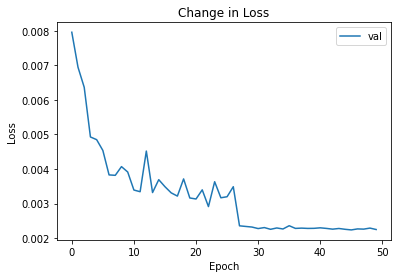

In [8]:
plt_data = {
    "val": test_losses
}
plot_graph(plt_data, "Loss")

## Plot Validation Accuracy

Plot the change in validation accracy vs epochs

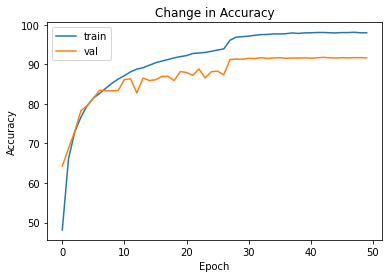

In [9]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

## Visualize GradCAM

Use GradCAM to understand where the network is looking at while prediction

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

### GradCAM for incorrectly classified images

Layer wise visualization of GradCAM for misclassified images

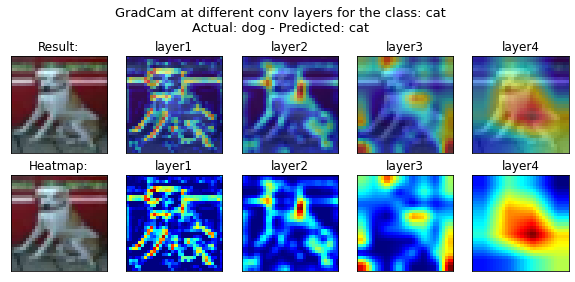

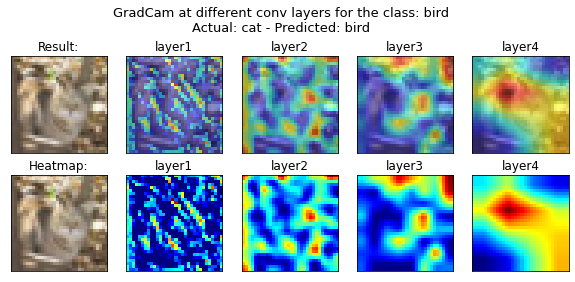

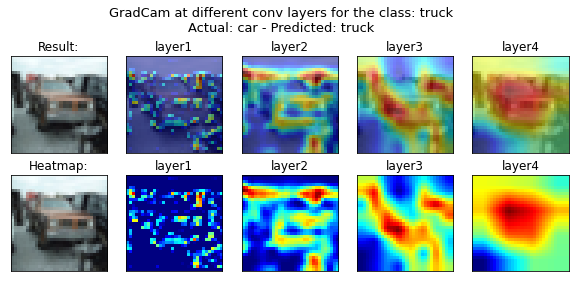

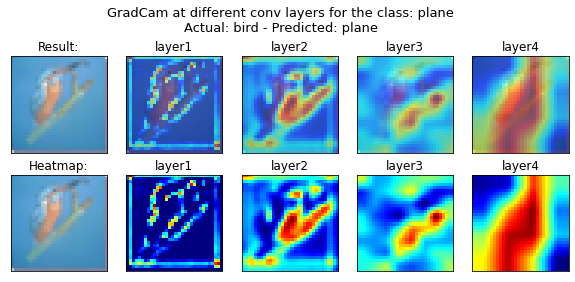

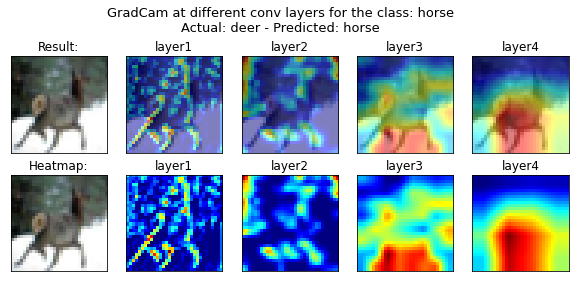

In [11]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

Layer 4 GradCAM visualisation for 25 misclassified images

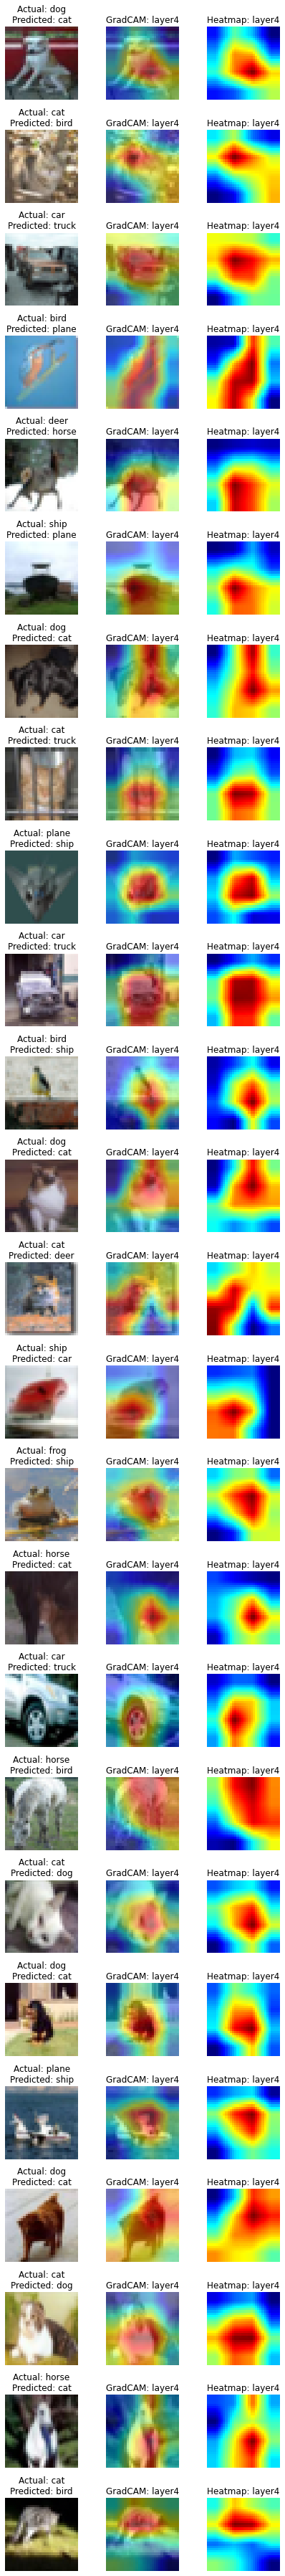

In [12]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)